
**Irena Zimovska**,  **Pola Parol**, **Natalia Miela**  
Faculty Of Economic Sciences UW  
January, 2024


# Analysis of Russian Constitutional Court Proceedings 

### What is this project about?
Over the past years, the development of Machine Learning and Artificial Intelligence has brought more attention to quantitative methods for the analysis of text data in the field of law. The applications of text mining can present various objectives and uses: those are implemented both as supervised methods (e.g., to make predictions of judiciary decisions as discussed by Medvedeva et al. 2019) and unsupervised, to conduct a historical analysis of the available corpus of legal documents.

This case study is inspired by the paper of Wendel et al. 2022, implementing a topic modeling approach to proceedings of the German Constitutional Court. More specifically, the aim of the exercise is to delve deeper into the caveats and techniques of processing Russian legal lexicon and attempt to grasp a preliminary image of available data.

### Legal introduction
**The Constitutional Court of Russian Federation** (руc. Конституционный Суд Российской Федерации) is a high court within the judiciary of Russia which is empowered to rule on whether certain laws or presidential decrees are in fact contrary to the Constitution of Russia. It's objective is to protect the Constitution and support population in terms of explaining the meaning of legal acts.

Th Court consists of 11 judges, one being the Chairman (currently Valery Zorkin) and another one being Deputy Chairman. The Chairman is responsible for the allocation of cases to chambers, has considerable powers in the matters of appointment, and makes the initial recommendation for disciplinary measures, in particular dismissal.


## Data Preview

In [165]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/irenaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [587]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import re

#NLTK & others
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('punkt') 
from pymystem3 import Mystem
import gensim.models
import navec

# LDA 
from sklearn.decomposition import LatentDirichletAllocation

# visualisations
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
pyLDAvis.enable_notebook()

[nltk_data] Downloading package punkt to /Users/irenaz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [588]:
data = pd.read_csv('legal_text_corpus.csv')

In [589]:
# 2953 documents
data.shape

(2963, 5)

In [590]:
data.head()

,Название документа,Ссылка,Текст,Комментарий РГ,Дата
0,Указ временно исполняющего обязанности главы Д...,https://rg.ru/documents/2022/11/28/dnr-ukaz37-...,1. Внести в Указ временно исполняющего обязанн...,Врио главы ДНР Денис Пушилин подписал указ об ...,2022-11-28
1,Постановление Конституционного Суда Российской...,https://rg.ru/documents/2022/11/25/document-ob...,Именем Российской Федерации Конституционный С...,"Бессрочный запрет на профессию для адвокатов, ...",2022-11-25
2,Постановление Пленума Верховного Суда Российск...,https://rg.ru/documents/2022/11/25/document-pl...,В целях обеспечения единства практики применен...,Пленум Верховного суда России утвердил постано...,2022-11-25
3,Федеральный закон от 21 ноября 2022 г. N 443-Ф...,https://rg.ru/documents/2022/11/24/document-na...,Принят Государственной Думой 10 ноября 2022 го...,На сладкую газировку с 1 июля 2023 года введут...,2022-11-24
4,Федеральный закон от 21 ноября 2022 г. N 448-Ф...,https://rg.ru/documents/2022/11/24/document-by...,Принят Государственной Думой 10 ноября 2022 го...,Приостановленное в этом году бюджетное правило...,2022-11-24


The dataset contains the following fields: 
1) Name of the document (Название документа)
2) Link (Ссылка)
3) Text (Текст)
4) The comment by Rossiyskaya Gazeta (Комментарий РГ)
5) Date (Дата)

In [591]:
# Let us translate the names of columns from Russian for the work convenience

data.rename(columns={"Название документа": "act_name"}, inplace=True)
data.rename(columns={"Ссылка": "link"}, inplace=True)
data.rename(columns={"Текст": "act_content"}, inplace=True)
data.rename(columns={"Комментарий РГ": "rg_comment"}, inplace=True)
data.rename(columns={"Дата": "date"}, inplace=True)

# We also change the order of columns 
data = data.reindex(columns=['date', 'act_name', 'act_content', 'rg_comment', 'link'])

In [592]:
data['date'] = pd.to_datetime(data['date'], format= '%Y-%m-%d')

In [593]:
data
# we have 2 693 documents

,date,act_name,act_content,rg_comment,link
0,2022-11-28,Указ временно исполняющего обязанности главы Д...,1. Внести в Указ временно исполняющего обязанн...,Врио главы ДНР Денис Пушилин подписал указ об ...,https://rg.ru/documents/2022/11/28/dnr-ukaz37-...
1,2022-11-25,Постановление Конституционного Суда Российской...,Именем Российской Федерации Конституционный С...,"Бессрочный запрет на профессию для адвокатов, ...",https://rg.ru/documents/2022/11/25/document-ob...
2,2022-11-25,Постановление Пленума Верховного Суда Российск...,В целях обеспечения единства практики применен...,Пленум Верховного суда России утвердил постано...,https://rg.ru/documents/2022/11/25/document-pl...
3,2022-11-24,Федеральный закон от 21 ноября 2022 г. N 443-Ф...,Принят Государственной Думой 10 ноября 2022 го...,На сладкую газировку с 1 июля 2023 года введут...,https://rg.ru/documents/2022/11/24/document-na...
4,2022-11-24,Федеральный закон от 21 ноября 2022 г. N 448-Ф...,Принят Государственной Думой 10 ноября 2022 го...,Приостановленное в этом году бюджетное правило...,https://rg.ru/documents/2022/11/24/document-by...
...,...,...,...,...,...
2958,2009-08-14,Постановление о совершенствовании госрегулиров...,Правительство Российской Федерации постановляе...,Производители жизненно необходимых и важнейших...,https://rg.ru/2009/08/14/lekarstva-dok.html
2959,2009-08-12,"Правила оплаты проезда осужденных, самостоятел...",В соответствии с частью второй статьи 751 Угол...,"Правительство утвердило новые правила, как опл...",https://rg.ru/2009/08/12/pravila-dok.html
2960,2009-08-20,Изменения в постановление правительства о него...,Правительство Российской Федерации постановляе...,Частные охранники и детективы должны будут про...,https://rg.ru/2009/08/07/sysk-izmenenia-dok.html
2961,2009-08-20,Постановление Главного госсанврача о надзоре з...,Зарегистрирован в Минюсте РФ 10 июля 2009 г. ...,В России усилят контроль за производством и об...,https://rg.ru/2009/08/05/bad-dok.html


In [594]:
# remove missings
data = data.dropna()

In [595]:
data.shape
# just a few rows were omitted

(2956, 5)

In [596]:
act_counts = data.groupby('date').size().reset_index(name='counts')
#.size().reset_index(name='Article Count')

# Create a line chart
fig = px.line(act_counts, x='date', y='counts', title='Number of Acts Published Over Time')
fig.show()

/Users/irenaz/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



From this chart one may notice that the frequency of publishing texts increased since 2018.

In [597]:
# We may look at one random publication to grasp the idea how texts look like. 
data.iloc[4]['act_name']

'Федеральный закон от 21 ноября 2022 г. N 448-ФЗ "О внесении изменений в Бюджетный кодекс Российской Федерации и отдельные законодательные акты Российской Федерации, приостановлении действия отдельных положений Бюджетного кодекса Российской Федерации, признании утратившими силу отдельных положений законодательных актов Российской Федерации и об установлении особенностей исполнения бюджетов бюджетной системы Российской Федерации в 2023 году" - Российская газета'

In [598]:
data.iloc[4]['act_content']

'Принят Государственной Думой 10 ноября 2022 года  Одобрен Советом Федерации 16 ноября 2022 года  Статья 1  Внести в Бюджетный кодекс Российской Федерации (Собрание законодательства Российской Федерации, 1998, N 31, ст. 3823; 2000, N 32, ст. 3339; 2002, N 22, ст. 2026; 2003, N 52, ст. 5036; 2004, N 34, ст. 3535; 2005, N 27, ст. 2717; N 52, ст. 5572; 2006, N 45, ст. 4627; N 50, ст. 5279; N 52, ст. 5503; 2007, N 1, ст. 28; N 18, ст. 2117; N 31, ст. 4009; N 45, ст. 5424; N 46, ст. 5553; N 50, ст. 6246; 2008, N 30, ст. 3597, 3617; N 48, ст. 5500; 2009, N 1, ст. 18; N 15, ст. 1780; N 29, ст. 3582, 3629; N 30, ст. 3739; N 39, ст. 4532; N 48, ст. 5733; N 52, ст. 6450; 2010, N 19, ст. 2291, 2293; N 21, ст. 2524; N 31, ст. 4185; N 46, ст. 5918; 2011, N 15, ст. 2041; N 41, ст. 5635; N 49, ст. 7030, 7039; 2012, N 26, ст. 3447; N 31, ст. 4316, 4317; N 50, ст. 6967; N 53, ст. 7593; 2013, N 19, ст. 2331; N 27, ст. 3480; N 30, ст. 4083; N 31, ст. 4191; N 52, ст. 6983; 2014, N 30, ст. 4250, 4267; N 40

In [275]:
data.iloc[4]['rg_comment']

'Приостановленное в этом году бюджетное правило, которое Минфин использовал для снижения зависимости федерального бюджета от цен на нефть и формирования резервов, снова возрождается, но в измененном виде. В нем больше не будет специальной "цены отсечения" для нефти и накоплений в недружественных валютах. Правда, выбор для формирования "подушки безопасности" теперь небогатый: фактически это юань, рубль и золото. Закон о новом бюджетном правиле публикует "Российская газета".\nПоследняя версия бюджетного правила, действовавшая с 2017 года (в целом бюджетное правило существует в России с 2004 года), фиксировала цену на нефть российской марки Urals на уровне 40 долларов за баррель с индексацией на 2% каждый год. Все нефтегазовые доходы сверх этой цены направлялись в резервы посредством покупки иностранной валюты (в подавляющем большинстве это были доллары и евро), а остальные нефтегазовые доходы тратились на текущие расходы бюджета. При снижении нефтяных цен Urals менее 40 долларов за барре

As usual for legal texts, the original legal act content of the Court contains lots of references to other acts and is very specific in terms of what edits should be introduced to the existing act. We are lucky to have those comments of newspaper, as the semantic content is translated.

## Text Data Processing

**Text preparation**

**Step 1** - tokenize sentences  
**Step 2** - change capitals to lower 
**Step 3** - omit numbers and punctuation  
**Step 4** - lemmatize tokens  
**Step 5** - remove stopwords  

We will create one function for preprocessing text and apply it on the field with the comments of RG on the Court's acts.

In [599]:
def preprocessText(text, stop_words, stemmer): 
    # Check if text is not a float
    if isinstance(text, float):
        return []
    # nltk tokenizer
    tokens = word_tokenize(text)
    clean_text = []
    for token in tokens: 
        # include only words with regex expression
        if re.search('[а-яА-Я]',str(token)): 
            token.lower()
            # pymystem3 library lemmatization
            lemma = stemmer.lemmatize(token)[0]
            if lemma not in stop_words: 
                clean_text.append(lemma)

    return clean_text


In [600]:
punctuation_marks = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*',
                     '+', ',', '-', '.', '/', ':', ';', '<', '=', '>',
                     '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}',
                     '~']

russian_stop_words = stopwords.words('russian')
stemmer = Mystem()

In [601]:
data[0:5].apply(lambda row: preprocessText(row['rg_comment'], russian_stop_words, stemmer), axis = 1)


0    [врио, глава, ДНР, денис, пушилин, подписывать...
1    [бессрочный, запрет, профессия, адвокат, осужд...
2    [пленум, верховный, судно, россия, утверждать,...
3    [сладкий, газировка, июль, год, вводить, акциз...
4    [приостанавливать, это, год, бюджетный, правил...
dtype: object

In [602]:
word = 'ходил '

In [603]:
Mystem().lemmatize(word)[0]

'ходить'

In [604]:
data['rg_comment_lemma'] = data.apply(lambda row: preprocessText(row['rg_comment'], russian_stop_words, stemmer), axis = 1)

/var/folders/yl/_w7r8c3d6zb68c8r6cb5j2hw0000gn/T/ipykernel_43332/87660907.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [605]:
data.head()

,date,act_name,act_content,rg_comment,link,rg_comment_lemma
0,2022-11-28,Указ временно исполняющего обязанности главы Д...,1. Внести в Указ временно исполняющего обязанн...,Врио главы ДНР Денис Пушилин подписал указ об ...,https://rg.ru/documents/2022/11/28/dnr-ukaz37-...,"[врио, глава, ДНР, денис, пушилин, подписывать..."
1,2022-11-25,Постановление Конституционного Суда Российской...,Именем Российской Федерации Конституционный С...,"Бессрочный запрет на профессию для адвокатов, ...",https://rg.ru/documents/2022/11/25/document-ob...,"[бессрочный, запрет, профессия, адвокат, осужд..."
2,2022-11-25,Постановление Пленума Верховного Суда Российск...,В целях обеспечения единства практики применен...,Пленум Верховного суда России утвердил постано...,https://rg.ru/documents/2022/11/25/document-pl...,"[пленум, верховный, судно, россия, утверждать,..."
3,2022-11-24,Федеральный закон от 21 ноября 2022 г. N 443-Ф...,Принят Государственной Думой 10 ноября 2022 го...,На сладкую газировку с 1 июля 2023 года введут...,https://rg.ru/documents/2022/11/24/document-na...,"[сладкий, газировка, июль, год, вводить, акциз..."
4,2022-11-24,Федеральный закон от 21 ноября 2022 г. N 448-Ф...,Принят Государственной Думой 10 ноября 2022 го...,Приостановленное в этом году бюджетное правило...,https://rg.ru/documents/2022/11/24/document-by...,"[приостанавливать, это, год, бюджетный, правил..."


In [606]:
def listToString(s):  
    strng = ""   
    for element in s:  
        strng += element+" "    
    return strng

In [607]:
data['rg_comment_lemma_str'] = data['rg_comment_lemma']

/var/folders/yl/_w7r8c3d6zb68c8r6cb5j2hw0000gn/T/ipykernel_43332/1241749449.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [608]:
# Apply the function to the 'rg_comment' column
data['rg_comment_lemma_str'] = data['rg_comment_lemma_str'].apply(listToString)

/var/folders/yl/_w7r8c3d6zb68c8r6cb5j2hw0000gn/T/ipykernel_43332/114314145.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Now we have representation of texts as lemmatized words. From this stage we are able to create a TFIDF matrix. 

## LDA topic modelling

**Document-Term and TF-IDF representation** 


Latent Dirichlet Allocation is a topic modelling technique which requires to set the number of topics we expect to retrive beforehand. At the same time, it is very hard to know it in advance, so it is rather a method of trial and verification - how many clusters our documents have. As the nature of legal documents is very broad in terms of thematics, we will first estimate 20 topics. 


LDA model can be built both on top of DTM matrix and TF-IDF. In our exercise we will apply DTM.

In [725]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

**Vectorizers**

In [610]:
# max_df - maximum % of documents the word may appear in 
# min_df - minimum number of document a word should appear in 
count_vectorizer = CountVectorizer(max_df = 0.2, min_df = 2)

# fit DTM matrix 
dtm = count_vectorizer.fit_transform(data['rg_comment_lemma_str'])

# extract feature names - words as keys 
dtm_feature_names = count_vectorizer.get_feature_names_out()

In [611]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.2, min_df = 2)

# fit tf idf matrix 
tfidf = tfidf_vectorizer.fit_transform(data['rg_comment_lemma_str'])

# extract feature names - words as keys 
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [612]:
print(dtm.shape)
print(tfidf.shape)

(2956, 14641)
(2956, 14641)


**LDA Topic Models**

In [613]:
# for TF DTM
lda_dtm = LatentDirichletAllocation(n_components=20, random_state=0)
lda_dtm.fit(dtm)


LatentDirichletAllocation(n_components=20, random_state=0)

In [614]:
# take a look at the output
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

We can look at the top frequent words per each topic.

In [615]:
no_top_words = 10
display_topics(lda_dtm, dtm_feature_names, no_top_words)


,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 15 words,Topic 15 weights,Topic 16 words,Topic 16 weights,Topic 17 words,Topic 17 weights,Topic 18 words,Topic 18 weights,Topic 19 words,Topic 19 weights
0,бюджет,619.7,голосование,292.0,ребенок,1167.5,штраф,509.4,режим,256.5,...,должность,441.9,судебный,598.4,указ,171.0,наркотик,92.8,трудовой,275.1
1,расход,375.6,партия,282.1,семья,338.2,оружие,490.9,область,250.3,...,владимир,379.3,судья,588.1,край,123.3,запрет,72.4,область,196.2
2,доход,287.2,кандидат,237.5,родитель,301.7,сотрудник,412.1,налоговый,174.7,...,помощник,363.7,судно,574.9,общественный,112.7,реклама,62.6,турист,182.7
3,миллиард,270.4,избирательный,231.0,женщина,251.8,безопасность,292.5,коронавирус,169.3,...,администрация,218.4,конституционный,325.5,октябрь,105.1,въезд,52.3,договор,169.4
4,экономика,241.3,выборы,216.6,детский,203.1,нарушение,287.2,вводить,145.8,...,сохранять,213.9,верховный,305.3,мероприятие,103.5,экстремистский,49.0,туроператор,160.3
5,уровень,240.1,комиссия,185.5,жизнь,188.6,информация,269.2,москва,141.1,...,путин,203.7,кс,253.4,дмитрий,90.6,запрещать,48.5,цена,133.2
6,развитие,238.5,госдума,178.4,сказать,175.2,ответственность,261.9,ограничение,122.5,...,кремль,184.7,постановление,240.5,ограничение,85.8,материал,46.7,труд,117.0
7,рост,216.7,выбор,160.2,проблема,157.0,полиция,249.1,инфекция,119.2,...,дмитрий,169.3,техосмотр,225.0,медведев,84.8,иностранец,45.3,работник,114.9
8,бюджетный,206.8,избиратель,156.0,то,152.2,административный,225.7,житель,113.3,...,сергей,168.4,правовой,193.4,чиновник,74.3,религиозный,41.4,товарищество,106.7
9,цена,162.8,депутат,144.0,очень,146.3,пассажир,220.3,предприниматель,110.4,...,полпред,165.8,инстанция,181.7,сообщать,74.1,интернет,41.1,тур,105.6


In [616]:
for index, component in enumerate(model.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(dtm_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index+1)+": ",top_terms_list)

Topic 1:  ['министр', 'заместитель', 'должность', 'область', 'развитие', 'председатель', 'управление', 'рождаться', 'оканчивать', 'директор']
Topic 2:  ['пенсия', 'фонд', 'компания', 'размер', 'пенсионный', 'страховой', 'банк', 'выплата', 'владимир', 'должность']
Topic 3:  ['военный', 'ребенок', 'семья', 'образование', 'бюджет', 'вуз', 'программа', 'развитие', 'иностранный', 'уровень']
Topic 4:  ['штраф', 'электронный', 'информация', 'сотрудник', 'наказание', 'нарушение', 'административный', 'оружие', 'уголовный', 'ответственность']
Topic 5:  ['налоговый', 'налог', 'судно', 'судья', 'судебный', 'статья', 'договор', 'конституционный', 'постановление', 'область']


**Visualizing topics - pyLDAvis**

Yet, more user friendly visualisation of topic semantics can be performed with pyLDAvis.

In [617]:
#pyLDAvis for our model
pyLDAvis.lda_model.prepare(lda_dtm, dtm, count_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.183457 -0.147060       1        1  32.915032
12     0.065283 -0.014861       2        1   7.566114
11     0.092578  0.124294       3        1   6.303036
3      0.084977  0.124426       4        1   6.061572
2      0.048650  0.003495       5        1   5.652297
10    -0.010295 -0.007771       6        1   4.373378
16     0.097715  0.067570       7        1   4.179284
7      0.105003  0.089066       8        1   3.998127
5      0.071523 -0.066611       9        1   3.776002
0     -0.015329 -0.218072      10        1   3.072089
1      0.039191  0.036516      11        1   3.035585
14     0.033451 -0.042243      12        1   2.957219
6      0.050500 -0.123455      13        1   2.769207
8     -0.018101 -0.100897      14        1   2.767659
4      0.009996  0.023304      15        1   2.713363
17    -0.033981  0.006762      16        1   2.291165
19    -0.002125 -0.083128      17        1   1.755871
15    -0.413399  0.137237      18        1   1.583841
9     -0.012445  0.024097      19        1   1.457870
18    -0.009736  0.167331      20        1   0.771289, topic_info=              Term         Freq        Total Category  logprob  loglift
3010     должность  2958.000000  2958.000000  Default  30.0000  30.0000
7326       область  3093.000000  3093.000000  Default  29.0000  29.0000
1568       военный  1400.000000  1400.000000  Default  28.0000  28.0000
10860      ребенок  2116.000000  2116.000000  Default  27.0000  27.0000
1583   возглавлять  1260.000000  1260.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
11568         сеть    23.044782   366.475571  Topic20  -5.6177   2.0984
4435         какой    24.352352   493.611347  Topic20  -5.5625   1.8557
4264    информация    26.102094  1036.144961  Topic20  -5.4931   1.1836
14453  электронный    25.150523   811.313435  Topic20  -5.5303   1.3911
11127    россиянин    22.086834   436.035377  Topic20  -5.6602   1.8821

[1516 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
5         17  0.926502    1262
11         8  0.944962     161
76        17  0.926502     597
80        11  0.069508      70
80        14  0.834101      70
...      ...       ...     ...
14617     14  0.127104  январь
14617     15  0.033381  январь
14617     16  0.029529  январь
14617     17  0.002568  январь
14617     20  0.006419  январь

[6791 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 13, 12, 4, 3, 11, 17, 8, 6, 1, 2, 15, 7, 9, 5, 18, 20, 16, 10, 19])

In [618]:
# as dimensionality reduction we can also use T-SNE
pyLDAvis.lda_model.prepare(lda_dtm, dtm, count_vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
13    -37.337090  53.877956       1        1  32.915032
12     83.480461 -13.727635       2        1   7.566114
11     42.552204 -19.166492       3        1   6.303036
3      19.690428 -46.619160       4        1   6.061572
2      38.891098  52.825359       5        1   5.652297
10     67.170341  24.105968       6        1   4.373378
16     66.192917 -52.596333       7        1   4.179284
7       0.953077 -87.742905       8        1   3.998127
5     -39.707096 -83.610382       9        1   3.776002
0      28.051178  12.554866      10        1   3.072089
1      40.430798 -83.597809      11        1   3.035585
14     -2.135895  30.073948      12        1   2.957219
6     -31.876606  10.456044      13        1   2.769207
8     -37.599426 -23.503778      14        1   2.767659
4     -76.582603 -12.239453      15        1   2.713363
17    -69.352051  27.570751      16        1   2.291165
19      1.616870  71.179901      17        1   1.755871
15    -15.703957 -50.321518      18        1   1.583841
9     -66.058899 -52.218410      19        1   1.457870
18      0.482801 -12.753687      20        1   0.771289, topic_info=              Term         Freq        Total Category  logprob  loglift
3010     должность  2958.000000  2958.000000  Default  30.0000  30.0000
7326       область  3093.000000  3093.000000  Default  29.0000  29.0000
1568       военный  1400.000000  1400.000000  Default  28.0000  28.0000
10860      ребенок  2116.000000  2116.000000  Default  27.0000  27.0000
1583   возглавлять  1260.000000  1260.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
11568         сеть    23.044782   366.475571  Topic20  -5.6177   2.0984
4435         какой    24.352352   493.611347  Topic20  -5.5625   1.8557
4264    информация    26.102094  1036.144961  Topic20  -5.4931   1.1836
14453  электронный    25.150523   811.313435  Topic20  -5.5303   1.3911
11127    россиянин    22.086834   436.035377  Topic20  -5.6602   1.8821

[1516 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
5         17  0.926502    1262
11         8  0.944962     161
76        17  0.926502     597
80        11  0.069508      70
80        14  0.834101      70
...      ...       ...     ...
14617     14  0.127104  январь
14617     15  0.033381  январь
14617     16  0.029529  январь
14617     17  0.002568  январь
14617     20  0.006419  январь

[6791 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 13, 12, 4, 3, 11, 17, 8, 6, 1, 2, 15, 7, 9, 5, 18, 20, 16, 10, 19])

We estimated a large number of topics and with this visualisation we can go deeper in verifying whether the topic makes sense. But what can be noticed from the initial preview is that indeed our Corpus of legal texts can be separated into categories. For example, the first, the largest topic is more general and can be charactarized by government issues: it contains words "minister", "management", 'economics", "position", "head", "development", etc. But as we go deeper, those topics become more specific, for example for topic 5 the top words are "child", "family", "parent", "woman", "life" which means that there is a separate category of texts devoted to the social policies development. Topic 6 is also specific: "military", "army", "soldier", "college". 

**Wordclouds**

Another way of visual representation are wordclouds.

In [619]:
dtm_feature_names = [re.sub(' ', '_', x) for x in dtm_feature_names]

In [620]:
def topic_by_index(model, feature_names, no_top_words, topic_index):
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx == topic_index):
            text = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
            wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
            plt.figure()
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.show()

In [621]:
# refit lda with 10 topics
lda_dtm = LatentDirichletAllocation(n_components=10, random_state=0)
lda_dtm.fit(dtm)

LatentDirichletAllocation(random_state=0)

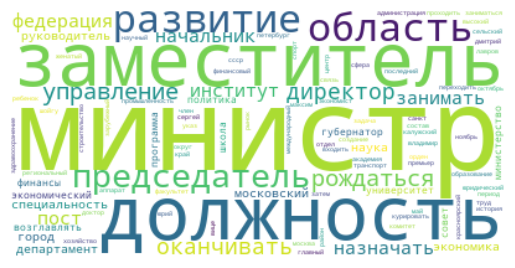

In [622]:
topic_by_index(lda_dtm, dtm_feature_names, 100, 0)

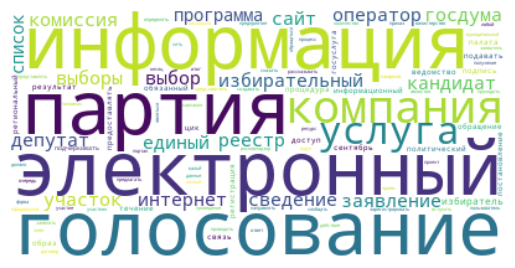

In [623]:
topic_by_index(lda_dtm, dtm_feature_names, 100, 1)

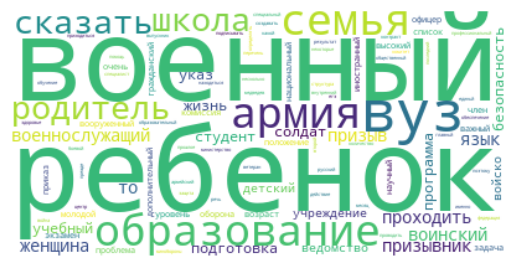

In [624]:
topic_by_index(lda_dtm, dtm_feature_names, 100, 2)

In [626]:
# document probabilities per topic 
doc_topic_probs = pd.DataFrame(lda_dtm.transform(dtm))
doc_topic_probs

,0,1,2,3,4,5,6,7,8,9
0,0.068072,0.002632,0.488189,0.143175,0.002632,0.002632,0.002632,0.002632,0.284772,0.002633
1,0.000516,0.000516,0.000516,0.000516,0.000516,0.000516,0.000516,0.995360,0.000516,0.000516
2,0.000415,0.000415,0.186108,0.123488,0.000415,0.000415,0.000415,0.687498,0.000415,0.000415
3,0.000901,0.000901,0.000901,0.000901,0.204058,0.000901,0.788733,0.000901,0.000901,0.000901
4,0.000287,0.000287,0.000287,0.000287,0.000287,0.000287,0.020533,0.000287,0.977174,0.000287
...,...,...,...,...,...,...,...,...,...,...
2951,0.000313,0.143133,0.000313,0.000313,0.780779,0.000313,0.073900,0.000313,0.000313,0.000313
2952,0.000575,0.000575,0.121292,0.438209,0.000575,0.059547,0.000575,0.377504,0.000575,0.000575
2953,0.001042,0.157547,0.238135,0.597025,0.001042,0.001042,0.001042,0.001042,0.001042,0.001042
2954,0.000885,0.000885,0.000885,0.000885,0.992034,0.000885,0.000885,0.000885,0.000885,0.000885


In further steps we would check the stability of topics in time - for that we need to group topic probabilities by dates and scale them. 

In [627]:
# merge data frames 
ata_lda_topics = pd.concat([data, doc_topic_probs], axis=1)
data_lda_topics

,date,act_name,act_content,rg_comment,link,rg_comment_lemma,rg_comment_lemma_str,0,1,2,3,4,5,6,7,8,9
0,2022-11-28,Указ временно исполняющего обязанности главы Д...,1. Внести в Указ временно исполняющего обязанн...,Врио главы ДНР Денис Пушилин подписал указ об ...,https://rg.ru/documents/2022/11/28/dnr-ukaz37-...,"[врио, глава, ДНР, денис, пушилин, подписывать...",врио глава ДНР денис пушилин подписывать указ ...,0.068072,0.002632,0.488189,0.143175,0.002632,0.002632,0.002632,0.002632,0.284772,0.002633
1,2022-11-25,Постановление Конституционного Суда Российской...,Именем Российской Федерации Конституционный С...,"Бессрочный запрет на профессию для адвокатов, ...",https://rg.ru/documents/2022/11/25/document-ob...,"[бессрочный, запрет, профессия, адвокат, осужд...",бессрочный запрет профессия адвокат осужденный...,0.000516,0.000516,0.000516,0.000516,0.000516,0.000516,0.000516,0.995360,0.000516,0.000516
2,2022-11-25,Постановление Пленума Верховного Суда Российск...,В целях обеспечения единства практики применен...,Пленум Верховного суда России утвердил постано...,https://rg.ru/documents/2022/11/25/document-pl...,"[пленум, верховный, судно, россия, утверждать,...",пленум верховный судно россия утверждать поста...,0.000415,0.000415,0.186108,0.123488,0.000415,0.000415,0.000415,0.687498,0.000415,0.000415
3,2022-11-24,Федеральный закон от 21 ноября 2022 г. N 443-Ф...,Принят Государственной Думой 10 ноября 2022 го...,На сладкую газировку с 1 июля 2023 года введут...,https://rg.ru/documents/2022/11/24/document-na...,"[сладкий, газировка, июль, год, вводить, акциз...",сладкий газировка июль год вводить акциз закон...,0.000901,0.000901,0.000901,0.000901,0.204058,0.000901,0.788733,0.000901,0.000901,0.000901
4,2022-11-24,Федеральный закон от 21 ноября 2022 г. N 448-Ф...,Принят Государственной Думой 10 ноября 2022 го...,Приостановленное в этом году бюджетное правило...,https://rg.ru/documents/2022/11/24/document-by...,"[приостанавливать, это, год, бюджетный, правил...",приостанавливать это год бюджетный правило кот...,0.000287,0.000287,0.000287,0.000287,0.000287,0.000287,0.020533,0.000287,0.977174,0.000287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2267,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.001471,0.001471,0.892460,0.001471,0.095771,0.001471,0.001471,0.001471,0.001471,0.001472
2303,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.000893,0.173414,0.819441,0.000893,0.000893,0.000893,0.000893,0.000893,0.000893,0.000893
2333,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.000405,0.000405,0.141170,0.000405,0.091171,0.000405,0.000405,0.764825,0.000405,0.000405
2341,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.001334,0.001334,0.078013,0.605024,0.112822,0.001334,0.001334,0.001333,0.196139,0.001333


In [628]:
data_lda_topics_grouped = data_lda_topics.groupby('date').sum()
data_lda_topics_grouped

,act_name,act_content,rg_comment,link,rg_comment_lemma,rg_comment_lemma_str,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,,,,,,,
2008-12-31,Закон о патентных поверенных — Российская газета,Принят Государственной Думой 24 декабря 2008 г...,В этом году деятельность патентных поверенных ...,https://rg.ru/2008/12/31/poverennie-dok.html,"[это, год, деятельность, патентный, поверенный...",это год деятельность патентный поверенный росс...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-01-15,"Требования к транспортным средствам, используе...",Правительство Российской Федерации постановляе...,Специфическим образом теперь должны быть раскр...,https://rg.ru/2009/01/15/trebovania-dok.htmlht...,"[специфический, образ, должный, раскрашивать, ...",специфический образ должный раскрашивать машин...,0.001874,0.412854,0.120242,0.879338,0.052317,0.118661,0.001874,0.001874,0.409092,0.001874
2009-01-16,Изменения в правила направления средств матери...,Правительство Российской Федерации постановляе...,Правительство утвердило изменения в правила на...,https://rg.ru/2009/01/16/matkapital-jilie-dok....,"[правительство, утвердить, изменение, правило,...",правительство утвердить изменение правило напр...,0.023823,0.387591,0.763547,0.776013,0.002576,0.286749,0.724851,0.018094,0.014182,0.002576
2009-01-21,Указ Президента о мерах по запрещению поставок...,Выписка В целях защиты национальных интересов...,"Страны, организации и отдельные люди, поставля...",https://rg.ru/2009/01/21/ukaz-gruzia-dok.htmlh...,"[страна, организация, отдельный, человек, пост...",страна организация отдельный человек поставлят...,0.339100,0.014340,1.217491,0.002245,0.002245,0.017650,0.002245,0.084381,0.247072,0.073230
2009-01-23,Приказ Минобрнауки об утверждении Порядка прие...,Зарегистрирован в Минюсте РФ 21 января 2009 г....,"Сегодня ""Российская газета"" публикует приказ м...",https://rg.ru/2009/01/23/vyzi-dok.htmlhttps://...,"[сегодня, российский, газета, публиковать, при...",сегодня российский газета публиковать приказ м...,0.065121,0.466524,0.181499,0.106507,0.098356,0.437772,0.376363,0.115121,0.151445,0.001293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-18,Указ временно исполняющего обязанности главы Д...,"1. Уволить с военной службы студентов, призван...",Указ об увольнении с военной службы студентов ...,https://rg.ru/documents/2022/11/18/dnr-ukaz30-...,"[указ, увольнение, военный, служба, студент, р...",указ увольнение военный служба студент республ...,0.003775,0.003774,1.068215,0.114505,0.003774,0.003774,0.003774,0.003774,0.790860,0.003775
2022-11-21,Федеральный закон от 18 ноября 2022 г. N 438-Ф...,Принят Государственной Думой 8 ноября 2022 год...,"""Российская газета"" публикует закон № 438-ФЗ ""...",https://rg.ru/documents/2022/11/21/document-kr...,"[российский, газета, публиковать, закон, 438, ...",российский газета публиковать закон 438 внесен...,0.000531,0.000531,0.347728,0.435927,0.000531,0.965010,0.000531,0.000531,0.248152,0.000531
2022-11-24,Федеральный закон от 21 ноября 2022 г. N 443-Ф...,Принят Государственной Думой 10 ноября 2022 го...,На сладкую газировку с 1 июля 2023 года введут...,https://rg.ru/documents/2022/11/24/document-na...,"[сладкий, газировка, июль, год, вводить, акциз...",сладкий газировка июль год вводить акциз закон...,0.121750,0.003846,0.953416,0.003846,0.410161,0.537268,2.004401,0.003846,1.957621,0.003846


In [637]:
data_lda_topics_grouped['sum'] = data_lda_topics_grouped.loc[:, 7:].sum(axis = 1)
data_lda_topics_grouped


,act_name,act_content,rg_comment,link,rg_comment_lemma,rg_comment_lemma_str,0,1,2,3,4,5,6,7,8,9,sum
date,,,,,,,,,,,,,,,,,
2008-12-31,Закон о патентных поверенных — Российская газета,Принят Государственной Думой 24 декабря 2008 г...,В этом году деятельность патентных поверенных ...,https://rg.ru/2008/12/31/poverennie-dok.html,"[это, год, деятельность, патентный, поверенный...",это год деятельность патентный поверенный росс...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-01-15,"Требования к транспортным средствам, используе...",Правительство Российской Федерации постановляе...,Специфическим образом теперь должны быть раскр...,https://rg.ru/2009/01/15/trebovania-dok.htmlht...,"[специфический, образ, должный, раскрашивать, ...",специфический образ должный раскрашивать машин...,0.001874,0.412854,0.120242,0.879338,0.052317,0.118661,0.001874,0.001874,0.409092,0.001874,0.825678
2009-01-16,Изменения в правила направления средств матери...,Правительство Российской Федерации постановляе...,Правительство утвердило изменения в правила на...,https://rg.ru/2009/01/16/matkapital-jilie-dok....,"[правительство, утвердить, изменение, правило,...",правительство утвердить изменение правило напр...,0.023823,0.387591,0.763547,0.776013,0.002576,0.286749,0.724851,0.018094,0.014182,0.002576,0.069702
2009-01-21,Указ Президента о мерах по запрещению поставок...,Выписка В целях защиты национальных интересов...,"Страны, организации и отдельные люди, поставля...",https://rg.ru/2009/01/21/ukaz-gruzia-dok.htmlh...,"[страна, организация, отдельный, человек, пост...",страна организация отдельный человек поставлят...,0.339100,0.014340,1.217491,0.002245,0.002245,0.017650,0.002245,0.084381,0.247072,0.073230,0.809367
2009-01-23,Приказ Минобрнауки об утверждении Порядка прие...,Зарегистрирован в Минюсте РФ 21 января 2009 г....,"Сегодня ""Российская газета"" публикует приказ м...",https://rg.ru/2009/01/23/vyzi-dok.htmlhttps://...,"[сегодня, российский, газета, публиковать, при...",сегодня российский газета публиковать приказ м...,0.065121,0.466524,0.181499,0.106507,0.098356,0.437772,0.376363,0.115121,0.151445,0.001293,0.535717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-18,Указ временно исполняющего обязанности главы Д...,"1. Уволить с военной службы студентов, призван...",Указ об увольнении с военной службы студентов ...,https://rg.ru/documents/2022/11/18/dnr-ukaz30-...,"[указ, увольнение, военный, служба, студент, р...",указ увольнение военный служба студент республ...,0.003775,0.003774,1.068215,0.114505,0.003774,0.003774,0.003774,0.003774,0.790860,0.003775,1.596817
2022-11-21,Федеральный закон от 18 ноября 2022 г. N 438-Ф...,Принят Государственной Думой 8 ноября 2022 год...,"""Российская газета"" публикует закон № 438-ФЗ ""...",https://rg.ru/documents/2022/11/21/document-kr...,"[российский, газета, публиковать, закон, 438, ...",российский газета публиковать закон 438 внесен...,0.000531,0.000531,0.347728,0.435927,0.000531,0.965010,0.000531,0.000531,0.248152,0.000531,0.498426
2022-11-24,Федеральный закон от 21 ноября 2022 г. N 443-Ф...,Принят Государственной Думой 10 ноября 2022 го...,На сладкую газировку с 1 июля 2023 года введут...,https://rg.ru/documents/2022/11/24/document-na...,"[сладкий, газировка, июль, год, вводить, акциз...",сладкий газировка июль год вводить акциз закон...,0.121750,0.003846,0.953416,0.003846,0.410161,0.537268,2.004401,0.003846,1.957621,0.003846,3.930627


In [639]:
data_topics_scaled = data_lda_topics_grouped.loc[:, 0:9].div(data_lda_topics_grouped['sum'], axis = 0)
data_topics_scaled = data_topics_scaled.reset_index()
data_topics_scaled

,date,0,1,2,3,4,5,6,7,8,9
0,2008-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-15,0.002270,0.500018,0.145629,1.064989,0.063362,0.143713,0.002270,0.002269,0.495461,0.002269
2,2009-01-16,0.341779,5.560715,10.954503,11.133361,0.036953,4.113947,10.399338,0.259589,0.203460,0.036951
3,2009-01-21,0.418970,0.017718,1.504251,0.002774,0.002774,0.021807,0.002774,0.104256,0.305266,0.090478
4,2009-01-23,0.121559,0.870840,0.338796,0.198812,0.183596,0.817170,0.702542,0.214891,0.282696,0.002413
...,...,...,...,...,...,...,...,...,...,...,...
875,2022-11-18,0.002364,0.002364,0.668965,0.071708,0.002364,0.002363,0.002363,0.002363,0.495273,0.002364
876,2022-11-21,0.001065,0.001065,0.697652,0.874608,0.001065,1.936116,0.001065,0.001065,0.497871,0.001064
877,2022-11-24,0.030975,0.000979,0.242561,0.000979,0.104350,0.136688,0.509944,0.000978,0.498043,0.000979
878,2022-11-25,0.000276,0.000276,0.055387,0.036803,0.000276,0.000276,0.000276,0.499448,0.000276,0.000276


In [641]:
data_topics_scaled['date'] = pd.to_datetime(data_topics_scaled['date'])
data_topics_scaled = data_topics_scaled.sort_values(by = "date")

In [642]:
data_topics_scaled

,date,0,1,2,3,4,5,6,7,8,9
0,2008-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-15,0.002270,0.500018,0.145629,1.064989,0.063362,0.143713,0.002270,0.002269,0.495461,0.002269
2,2009-01-16,0.341779,5.560715,10.954503,11.133361,0.036953,4.113947,10.399338,0.259589,0.203460,0.036951
3,2009-01-21,0.418970,0.017718,1.504251,0.002774,0.002774,0.021807,0.002774,0.104256,0.305266,0.090478
4,2009-01-23,0.121559,0.870840,0.338796,0.198812,0.183596,0.817170,0.702542,0.214891,0.282696,0.002413
...,...,...,...,...,...,...,...,...,...,...,...
875,2022-11-18,0.002364,0.002364,0.668965,0.071708,0.002364,0.002363,0.002363,0.002363,0.495273,0.002364
876,2022-11-21,0.001065,0.001065,0.697652,0.874608,0.001065,1.936116,0.001065,0.001065,0.497871,0.001064
877,2022-11-24,0.030975,0.000979,0.242561,0.000979,0.104350,0.136688,0.509944,0.000978,0.498043,0.000979
878,2022-11-25,0.000276,0.000276,0.055387,0.036803,0.000276,0.000276,0.000276,0.499448,0.000276,0.000276


In [648]:
def topic_temporal_distribution(dates, shares):
    plt.style.use("fivethirtyeight")
    plt.plot(dates, shares)
    plt.xlabel("Date")
    plt.ylabel("Topic's share")
    frame = plt.gca()
    plt.xticks(rotation = 75)
    plt.show()

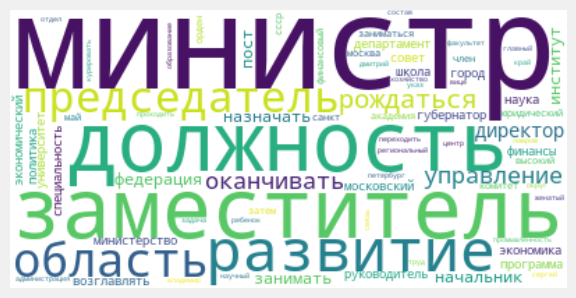

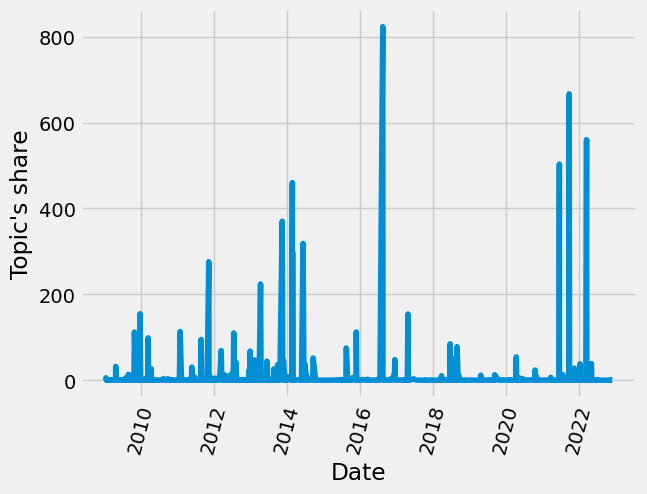

In [656]:
i = 0
topic_by_index(lda_dtm, dtm_feature_names, 100, i) #wordcloud for context
topic_temporal_distribution(data_topics_scaled['date'], data_topics_scaled[i+1])


## Named Entity Recognition with Natasha

In [657]:
# ! pip install natasha

In [658]:
from natasha import (NewsNERTagger,
    NewsEmbedding,
    PER,
    NamesExtractor,
    Segmenter,
    MorphVocab,
    Doc)

In [659]:
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)
segmenter = Segmenter()
morph_vocab = MorphVocab()

In [660]:
text = str(data.iloc[25]['rg_comment'])
print(text)

Президент РФ Владимир Путин подписал пакет документов о воссоединении Донецкой и Луганской народных республик, Херсонской и Запорожской областей с Российской Федерацией. Теперь изменения будут внесены в Конституцию РФ.
Напомним, что президент РФ 30 сентября подписал вместе с руководством ДНР, ЛНР, Запорожской и Херсонской областей договоры о вхождении их в РФ в качестве новых регионов. Конституционный суд 2 октября счел документы соответствующим Основному Закону государства. После этого Госдума и Совфед единогласно ратифицировали договоры и приняли проекты федеральных конституционных законов (ФКЗ) о вхождении в состав страны новых территорий и образовании в ее составе новых субъектов.
На главные вопросы, связанные с процессом интеграции, ранее ответили депутаты, сенаторы, представители правительства.
В России теперь 89 регионов, ее население увеличилось почти на 6,2 млн человек и составляет более 152 млн человек. Площадь РФ увеличилась более чем на 100 тысяч квадратных километров.
Согл

In [661]:
# The text should be stored in object Doc 
doc = Doc(text)
doc.segment(segmenter)
print(doc)

Doc(text='Президент РФ Владимир Путин подписал пакет докуме..., tokens=[...], sents=[...])


In [662]:
doc.tag_ner(ner_tagger)

The extraction in `natasha` is performed with the help of library `NER`. What is fantastic, is that we can display the document directly with matched entities identified. Further we will extract those as separate features. 

In [663]:
doc.ner.print()

Президент РФ Владимир Путин подписал пакет документов о воссоединении 
          LO PER───────────                                           
Донецкой и Луганской народных республик, Херсонской и Запорожской 
LOC─────   LOC─────────────────────────  LOC───────   LOC─────────
областей с Российской Федерацией. Теперь изменения будут внесены в 
────────   LOC──────────────────                                   
Конституцию РФ.
            LO 
Напомним, что президент РФ 30 сентября подписал вместе с руководством 
                        LO                                            
ДНР, ЛНР, Запорожской и Херсонской областей договоры о вхождении их в 
LOC  LOC  LOC────────   LOC────────────────                           
РФ в качестве новых регионов. Конституционный суд 2 октября счел 
LO                            ORG────────────────                
документы соответствующим Основному Закону государства. После этого 
Госдума и Совфед единогласно ратифицировали договоры и приняли проекты


In [665]:
for span in doc.spans: 
    span.normalize(morph_vocab)
    print('Before normalization:', {span.text}, 'After:', {span.normal})
    

Before normalization: {'РФ'} After: {'РФ'}
Before normalization: {'Владимир Путин'} After: {'Владимир Путин'}
Before normalization: {'Донецкой'} After: {'Донецкой'}
Before normalization: {'Луганской народных республик'} After: {'Луганской народных республик'}
Before normalization: {'Херсонской'} After: {'Херсонской'}
Before normalization: {'Запорожской областей'} After: {'Запорожской областей'}
Before normalization: {'Российской Федерацией'} After: {'Российской Федерацией'}
Before normalization: {'РФ'} After: {'РФ'}
Before normalization: {'РФ'} After: {'РФ'}
Before normalization: {'ДНР'} After: {'ДНР'}
Before normalization: {'ЛНР'} After: {'ЛНР'}
Before normalization: {'Запорожской'} After: {'Запорожской'}
Before normalization: {'Херсонской областей'} After: {'Херсонской областей'}
Before normalization: {'РФ'} After: {'РФ'}
Before normalization: {'Конституционный суд'} After: {'Конституционный суд'}
Before normalization: {'Госдума'} After: {'Госдума'}
Before normalization: {'Совфед'} A

In [666]:
def extract_named_entities(text): 
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)
    org_list = []
    name_list = []
    loc_list = []

    for span in doc.spans: 
        span.normalize(morph_vocab)

        if span.type == "ORG" and span.normal not in org_list:
            org_list.append(span.normal)
        
        if span.type == "PER" and span.normal not in name_list:
            name_list.append(span.normal)

        if span.type == "LOC" and span.normal not in loc_list:
            loc_list.append(span.normal)

    return org_list, name_list, loc_list


In [667]:
# Apply the function to the 'rg_comment' column
data[['organ', 'personas', 'location']] = data['rg_comment'].apply(extract_named_entities).apply(pd.Series)

/var/folders/yl/_w7r8c3d6zb68c8r6cb5j2hw0000gn/T/ipykernel_43332/1884683087.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yl/_w7r8c3d6zb68c8r6cb5j2hw0000gn/T/ipykernel_43332/1884683087.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yl/_w7r8c3d6zb68c8r6cb5j2hw0000gn/T/ipykernel_43332/1884683087.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [668]:
data.head()

,date,act_name,act_content,rg_comment,link,rg_comment_lemma,rg_comment_lemma_str,organ,personas,location
0,2022-11-28,Указ временно исполняющего обязанности главы Д...,1. Внести в Указ временно исполняющего обязанн...,Врио главы ДНР Денис Пушилин подписал указ об ...,https://rg.ru/documents/2022/11/28/dnr-ukaz37-...,"[врио, глава, ДНР, денис, пушилин, подписывать...",врио глава ДНР денис пушилин подписывать указ ...,[],"[Денис Пушилин, Владимир Путин, Пушилин]","[ДНР, ЛНР]"
1,2022-11-25,Постановление Конституционного Суда Российской...,Именем Российской Федерации Конституционный С...,"Бессрочный запрет на профессию для адвокатов, ...",https://rg.ru/documents/2022/11/25/document-ob...,"[бессрочный, запрет, профессия, адвокат, осужд...",бессрочный запрет профессия адвокат осужденный...,"[КС, Российская газета, ФЗ]","[Сергей Шалавин, Шалавина]",[РФ]
2,2022-11-25,Постановление Пленума Верховного Суда Российск...,В целях обеспечения единства практики применен...,Пленум Верховного суда России утвердил постано...,https://rg.ru/documents/2022/11/25/document-pl...,"[пленум, верховный, судно, россия, утверждать,...",пленум верховный судно россия утверждать поста...,"[Верховного суда, РГ, ВС, Ассоциации юристов Р...","[Владимир Груздев, Никита Филиппов, Екатерина ...",[России]
3,2022-11-24,Федеральный закон от 21 ноября 2022 г. N 443-Ф...,Принят Государственной Думой 10 ноября 2022 го...,На сладкую газировку с 1 июля 2023 года введут...,https://rg.ru/documents/2022/11/24/document-na...,"[сладкий, газировка, июль, год, вводить, акциз...",сладкий газировка июль год вводить акциз закон...,"[Российская газета, Евразийского экономическог...",[Михаил Мурашко],[РФ]
4,2022-11-24,Федеральный закон от 21 ноября 2022 г. N 448-Ф...,Принят Государственной Думой 10 ноября 2022 го...,Приостановленное в этом году бюджетное правило...,https://rg.ru/documents/2022/11/24/document-by...,"[приостанавливать, это, год, бюджетный, правил...",приостанавливать это год бюджетный правило кот...,"[Минфин, Российская газета, Фонд национального...","[Антон Силуанов, Силуанов, Михаил Васильев, Ва...","[России, Китае, КНР, США, Китай, Объединенных ..."


As you see, we successfully retrieved names, countries and location identifiers, as well as organisation names from the text. These may be helpful as new features for working with the dataset. One mportant notice is that spans obtained after normalization still contain some modified forms of names, so there is area for further improvement and processing. At the moment we will leave itt as it is and delve into attempting embeddings with Russian text.

## Fitting embeddings Word2Vec model with GenSim & Navec

Another option of text representation are word embeddings - vectorized numeric units for each word. 

In [669]:
import gensim.models 

In [670]:
model = gensim.models.Word2Vec(sentences=data['rg_comment_lemma'], min_count=5)

In [671]:
model.wv['указ']

array([-2.1781657 , -1.5194621 ,  1.3631636 , -0.13436066,  0.21790138,
        1.5367779 , -0.11544547, -0.21663913,  0.6401581 ,  1.651998  ,
       -0.9339212 ,  2.3346374 , -0.8875961 , -2.0898125 , -1.1684822 ,
       -1.4522086 ,  1.6715686 ,  1.9193338 ,  1.1451396 , -0.04259901,
       -0.28321415,  1.1268446 , -1.8394431 ,  1.1157991 , -0.3551111 ,
        0.30581993, -4.883176  , -0.55426455,  0.02194101,  0.8354496 ,
        0.5385642 , -0.16713351,  0.37208247,  1.1330448 , -1.9855435 ,
       -0.5162905 , -1.5787368 , -0.7281876 ,  1.198754  ,  0.11543919,
       -1.7430819 ,  0.649508  ,  0.07500936, -0.1439273 , -1.5351692 ,
       -0.16355525, -1.7552702 ,  0.79427993,  1.0084532 , -0.03453809,
        1.5312818 ,  0.04204175, -1.2608243 , -1.0655886 , -1.2319856 ,
       -4.518861  ,  0.29233176, -1.4145634 , -0.26349503, -2.1184955 ,
       -2.9993165 ,  0.1363038 ,  0.22892009, -0.80138403, -1.7028382 ,
       -1.2753446 , -2.0966315 ,  2.1784132 , -2.7827868 ,  0.65

In [672]:
model.wv['суд']

array([-8.9964944e-01, -1.8435915e+00, -1.6919049e+00,  2.8715792e+00,
       -4.9235633e-01,  3.1871161e-05, -1.5092634e+00, -1.5227522e-01,
       -1.7873055e+00,  1.4141604e+00, -5.4369086e-01, -1.0693018e+00,
        8.4124219e-01,  1.7116808e+00,  1.7428653e+00, -1.1939358e+00,
       -1.3585531e+00,  6.5475118e-01,  4.8444226e-01, -2.0616875e+00,
       -2.0404277e+00,  1.5951289e+00, -5.0317860e-01,  2.4486537e+00,
       -4.7788048e-01, -9.7823220e-01,  9.0889150e-01, -1.4411554e+00,
        1.3566915e+00,  8.2136339e-01,  2.8320813e+00, -1.3404168e+00,
       -4.3679330e-01, -7.6380469e-02,  1.4477019e-01, -1.9229598e+00,
        1.1905389e+00,  9.3908727e-01, -1.2404328e-01,  4.9426887e-02,
       -3.3542681e+00,  1.5127724e+00,  1.5835477e-01, -7.5300187e-01,
       -4.6156996e-01,  2.4780200e+00,  1.4231952e+00, -1.3349618e+00,
       -1.3102112e+00, -8.3667660e-01, -3.4959483e-01,  3.3481583e-01,
       -7.9675871e-01, -1.0931586e+00,  1.9526922e+00,  3.3658156e+00,
      

In [673]:
model.wv.most_similar('суд')

[('судно', 0.8320280909538269),
 ('судебный', 0.6902576684951782),
 ('судья', 0.6873763203620911),
 ('кс', 0.6867621541023254),
 ('инстанция', 0.669376790523529),
 ('жалоба', 0.6635211110115051),
 ('кассационный', 0.6467304825782776),
 ('рассматривать', 0.6387649178504944),
 ('вынести', 0.6250991225242615),
 ('иск', 0.623746931552887)]

In [674]:
model.wv.most_similar('указ')

[('майский', 0.8160474300384521),
 ('подписывать', 0.623836100101471),
 ('президентский', 0.5952994227409363),
 ('полномочный', 0.5825986266136169),
 ('путин', 0.5647905468940735),
 ('июнь', 0.5642032027244568),
 ('послание', 0.5614514350891113),
 ('собрание', 0.5470411777496338),
 ('президент', 0.5362355709075928),
 ('госсовет', 0.5356742143630981)]

In [675]:
model.wv.most_similar('верховный')

[('пленум', 0.806907057762146),
 ('арбитражный', 0.7835273742675781),
 ('кассационный', 0.7665163278579712),
 ('судно', 0.7369521856307983),
 ('конституционный', 0.7305551171302795),
 ('лебедев', 0.7148303389549255),
 ('заседатель', 0.6947495341300964),
 ('момот', 0.6935654282569885),
 ('апелляционный', 0.6906962990760803),
 ('нижестоящий', 0.6890591382980347)]

In [676]:
model.save('word2vec-court-ru')

In [677]:
!ls -lh

total 486664
-rw-r--r--@ 1 irenaz  staff   1.0M Jan 19 18:05 IMR_Putin-20-years-protests_eng.pdf
-rw-rw-r--@ 1 irenaz  staff   148M Feb 13  2023 legal_text_corpus.csv
-rw-r--r--@ 1 irenaz  staff   4.0K Jan 30 17:11 natasha.ipynb
-rw-r--r--@ 1 irenaz  staff    51M Jan 21 21:55 navec_hudlit_v1_12B_500K_300d_100q.tar
-rw-r--r--@ 1 irenaz  staff    25M Jan 30 13:08 navec_news_v1_1B_250K_300d_100q.tar
-rw-r--r--@ 1 irenaz  staff     6B Jan 21 17:11 requirements.txt
-rw-r--r--@ 1 irenaz  staff   2.7M Jan 30 19:54 script_russian.ipynb
-rw-r--r--@ 1 irenaz  staff   2.3M Jan 30 12:59 slovnet_ner_news_v1.tar
-rw-r--r--@ 1 irenaz  staff   7.7M Jan 30 19:55 word2vec-court-ru


In [678]:
len(model.wv.index_to_key)

9582

In [700]:
vocab = model.wv.index_to_key

In [706]:
type(vocab)

list

In [701]:
vocab_vectors = np.array([model.wv[word] for word in vocab])
print(vocab_vectors)


[[-1.1527388  -0.23253484  1.4187279  ... -1.258217    0.08549625
   1.2417736 ]
 [-0.48109427  0.17570108  0.11620519 ...  1.1038637  -1.0370951
  -0.85814136]
 [-0.26583534  0.03720997  0.42528662 ...  2.2749217  -0.24954624
  -0.6689424 ]
 ...
 [-0.09823562  0.06668901  0.07890491 ... -0.16185565  0.10880351
   0.0270338 ]
 [-0.08758693  0.0760437  -0.00867342 ... -0.06418552  0.0726506
   0.05584474]
 [-0.10705265  0.07707497 -0.01119438 ... -0.1079037   0.03861768
   0.04287248]]


In [722]:
# select some words of interest 
words = ["президент", "постановление", "суд","разрешение", "штраф","конституция", "искусство", "конституционный"]

index = []
for word in words: 
    index.append(vocab.index(word))

print(index)

[12, 152, 46, 516, 184, 608, 1777, 370]


In [723]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # init PCA object
pca_result = pca.fit_transform(vocab_vectors)


In [717]:
pca_result.shape

(9582, 2)

In [718]:
# With PCA we condensed 100 numeric items per word to 2. 

In [719]:
print("PCA Vectors: \n" + str(pca_result))

PCA Vectors: 
[[ 4.5366583  -0.27838406]
 [-1.1097238  -0.7537738 ]
 [-1.9620894  -1.4690902 ]
 ...
 [ 0.12933779 -0.01546576]
 [ 0.0787122   0.05031809]
 [-0.01250973  0.01419599]]


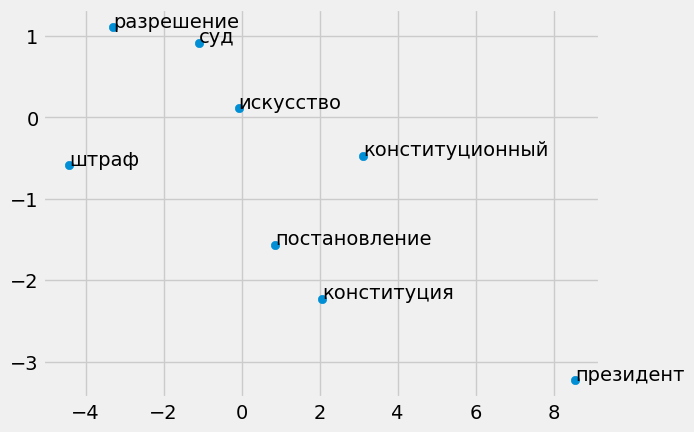

In [724]:
# create a scatter plot of the projection
plt.scatter(pca_result[index, 0], pca_result[index, 1])
for i in index: 
    word = vocab[i]
    plt.annotate(word, xy = (pca_result[i][0], pca_result[i][1]))
plt.show()

In [ ]:
# !wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar


In [ ]:
from navec import Navec

path = '/Users/irenaz/Desktop/Masters - DSBA/2 year/Text Mining/Project/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
navec['указ']

array([-0.2196427 , -0.07133308,  0.32015604,  0.4204174 ,  0.17428464,
        0.5928066 , -0.37674117, -0.40105772,  0.22673269, -0.8196949 ,
        0.18733615, -0.08808075,  0.3061927 ,  0.58062047,  0.37935448,
       -0.09167824, -0.20986402,  0.24238393, -0.03480947,  0.11684935,
        0.099706  , -0.45221522, -0.25535765,  0.5980893 ,  0.21536638,
       -0.52678525, -0.09569769,  0.02137613, -0.02893453,  0.50664586,
       -0.05011329, -0.55349374,  0.90142566,  0.36533636, -0.11256333,
        0.6622776 ,  0.21699315, -0.28250223, -0.22497949, -0.24493384,
       -0.05563323, -0.8015103 ,  0.12435891,  0.08286576, -0.51306933,
       -0.8856041 ,  0.45025486,  0.24697506,  0.25088063, -0.23368211,
       -0.42044204, -0.74274886, -0.13372403,  0.05404444, -0.2216356 ,
        0.15699024, -0.20823078,  0.48945817,  0.3946782 ,  0.55152255,
        0.34437457, -0.04082207,  0.48632532,  0.05067058,  0.06851733,
        0.4970712 ,  0.31102055, -0.44508085,  0.17855696, -0.78

In [ ]:
navec['суд']

array([-0.36315897,  0.3156473 ,  0.41194513, -0.18653584, -0.0491573 ,
       -0.01887514, -0.23079073, -0.14040163,  0.2734096 , -0.9237671 ,
       -0.28725535,  0.13564418,  0.09687979,  0.435942  ,  0.30951658,
        0.6303527 , -0.07044804,  0.21447837,  0.4341777 , -0.21785256,
        0.42719108,  0.00539496, -0.2937772 ,  0.04140832,  0.19679627,
        0.34577543,  0.33214954,  0.41782278, -0.02796733,  0.06922387,
        0.26940924, -0.11432096,  1.163183  ,  0.74607337, -0.3843334 ,
        0.42019406,  0.6627084 , -0.1732102 ,  0.07823543, -0.5328917 ,
        0.10871849,  0.22583814, -0.6742331 , -0.21957164,  0.16038276,
       -0.65532494, -0.23724943,  0.19871232, -0.39968663, -0.6195518 ,
       -0.06745401, -0.36541265, -0.20060915,  0.10681065, -0.3005228 ,
       -0.14394104, -0.06869197,  0.18652463,  0.03206391,  0.3074479 ,
       -0.30503905,  0.54091793,  0.21471608, -0.04691113, -0.09172899,
        0.1921914 , -0.04212292, -0.49340156, -0.50213677,  0.16